In [1]:
import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2

# PARTIE 1

## Chargement et visualisation des données

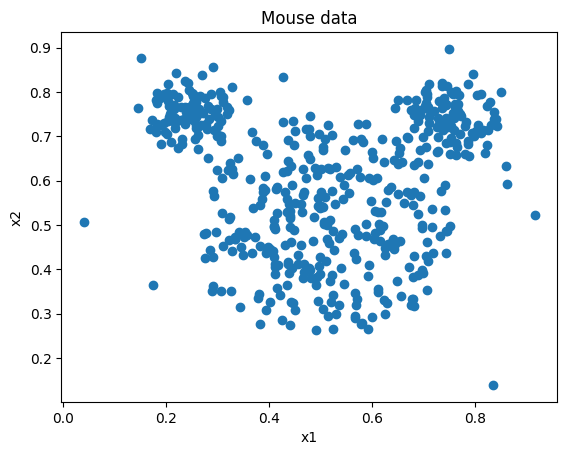

In [20]:
mickey = np.loadtxt('mouse.txt')
x1 = mickey[:,0]
x2 = mickey[:,1]

plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Mouse data')
plt.show()

## Isolation Forest

In [21]:

iforest = IsolationForest(n_estimators=100, max_samples='auto')
iforest.fit(mickey)

df = pd.DataFrame(mickey)
df['scores'] = iforest.decision_function(mickey)
# -1 for outliers, 1 for inliers
df['anomaly'] = iforest.predict(mickey)
df.head(20)

,0,1,scores,anomaly
0,0.456601,0.432806,0.034016,1
1,0.611378,0.528625,0.044017,1
2,0.450299,0.711606,0.031595,1
3,0.639015,0.460744,0.037279,1
4,0.628957,0.323470,-0.025271,-1
5,0.566210,0.289358,-0.042478,-1
6,0.567653,0.295473,-0.038766,-1
7,0.436024,0.415776,0.029462,1
8,0.545414,0.367502,0.003379,1
9,0.439453,0.547867,0.059480,1


In [22]:
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(len(anomaly))

125


## Local Outlier Factor

In [23]:

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred = lof.fit_predict(mickey)

# -1 for outliers, 1 for inliers
print(pred)


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1

## Mieux choisir le seuil de contamination

### Méthode 1 : Visualisation des anomalies - Isolation Forest

Pour cette méthode, nous allons visualiser l'histogramme des scores de l'Isolation Forest. Nous allons ensuite calculer le seuil de contamination optimal.

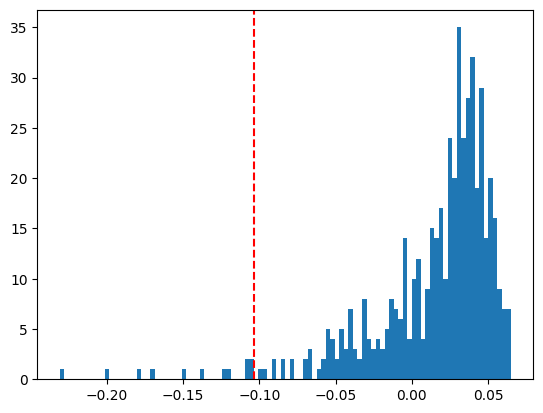

In [24]:
scrores = df['scores']

# récupérer les informations de l'histogramme
frequencies, bins = np.histogram(scrores, bins=100)

# calculer la pente de chaque barre
bin_diff = np.diff(bins)
slope = np.diff(frequencies) / bin_diff[:-1]

# trouver le seuil
threshold_index = np.where(slope < -np.abs(slope).max()*0.09)[0][0]
threshold = bins[threshold_index +1]

plt.hist(scrores, bins=100)
plt.axvline(threshold, color='red', linestyle='--')


In [25]:
nombre_sous_seuil = (df['scores'] < threshold).sum()
print("Pourcentage d'erreur : ",nombre_sous_seuil*100/len(df), '%')

Pourcentage d'erreur :  2.4 %


### Méthode 2 : Calculer le seuil avec un Z-score - Local Outlier Factor

Pour cette méthode, nous allons calculer le seuil de contamination optimal en utilisant un Z-score.

In [26]:
lof_scores = lof.negative_outlier_factor_
# Calcul du seuil avec Z-score
threshold = np.mean(lof_scores) - 3 * np.std(lof_scores)

print("Seuil LOF : ", threshold)
nombre_sous_seuil = (lof_scores < threshold).sum()
print("Pourcentage d'erreur LOF : ",nombre_sous_seuil*100/len(df), '%')

Seuil LOF :  -1.7885302876387439
Pourcentage d'erreur LOF :  1.6 %


## Visualisation des données aberrantes

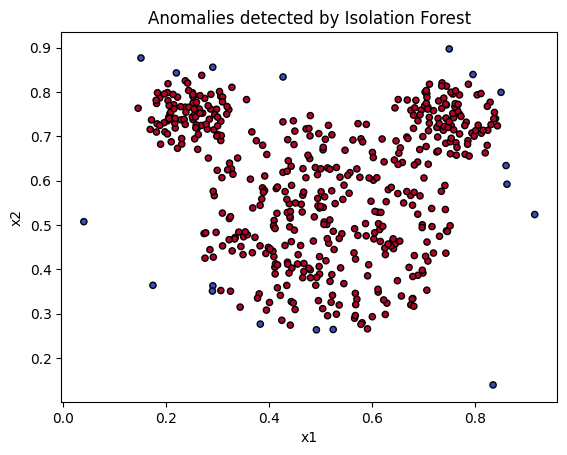

In [27]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.036)
iforest.fit(mickey)
df['scores'] = iforest.decision_function(mickey)
df['anomaly'] = iforest.predict(mickey)
plt.scatter(x1, x2, c=df['anomaly'], cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Isolation Forest')
plt.show()

In [28]:
# print les index des anomalies
anomaly = df.loc[df['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

[84, 165, 194, 217, 220, 387, 398, 424, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]


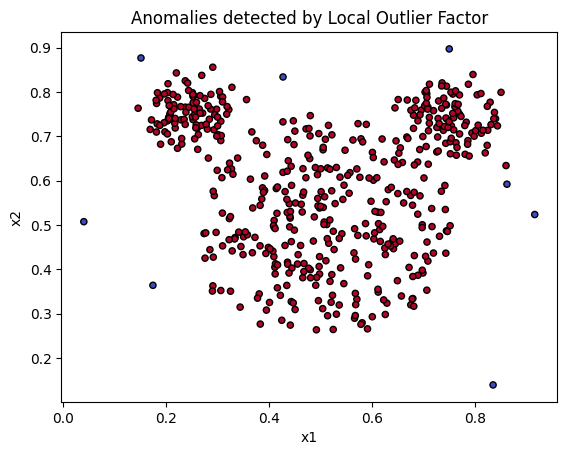

In [29]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.016)
pred = lof.fit_predict(mickey)
plt.scatter(x1, x2, c=pred, cmap='coolwarm', s=20, edgecolors='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Anomalies detected by Local Outlier Factor')
plt.show()

In [30]:
# print les index des anomalies
anomaly = df.loc[pred == -1]
anomaly_index = list(anomaly.index)
print(anomaly_index)

[491, 492, 493, 494, 495, 497, 498, 499]


## Comparaison des méthodes

La méthode Isolation Forest avec un seuil de contamination calculé grâce à l'histogramme, permet de détecter toutes les anomalies. Cepedant, elle détecter aussi des points comme étant anormal alors qu'il ne le sont pas. D'un autre côté, la méthode Local Outlier Factor avec Z-scores permet de détecter les anomalies mais ne les trouve pas toutes. Aucune méthode n'est meilleur que l'autre, cela dépend si l'on veut détecter toutes les anomalies ou si l'on veut éviter de faux positifs.

# PARTIE 2

## Préparation des données

In [2]:
from utilsfunction import preprocess_data, train__supervised_classic, train_supervised_imbalanced, print_metrics, plot_roc_pr_curves, train_and_evaluate_isforest, train_and_evaluate_lof, evaluate_model_cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import importlib, utilsfunction
importlib.reload(utilsfunction)

<module 'utilsfunction' from 'c:\\Users\\tomhu\\Desktop\\TAA_TP1\\utilsfunction.py'>

In [91]:
credit_card = pd.read_csv('creditcard.csv')
credit_card_features, credit_card_labels = preprocess_data(credit_card)

credit_card_features = pd.DataFrame(credit_card_features)

X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.2, random_state=42, stratify=credit_card_labels)

## Approche supervisée classique : Régression logistique

ROC AUC score :  0.8213142636063991
Average precision score :  0.5335091815596363
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC (Logistic Regression): 0.9589
PR AUC (Logistic Regression): 0.7416


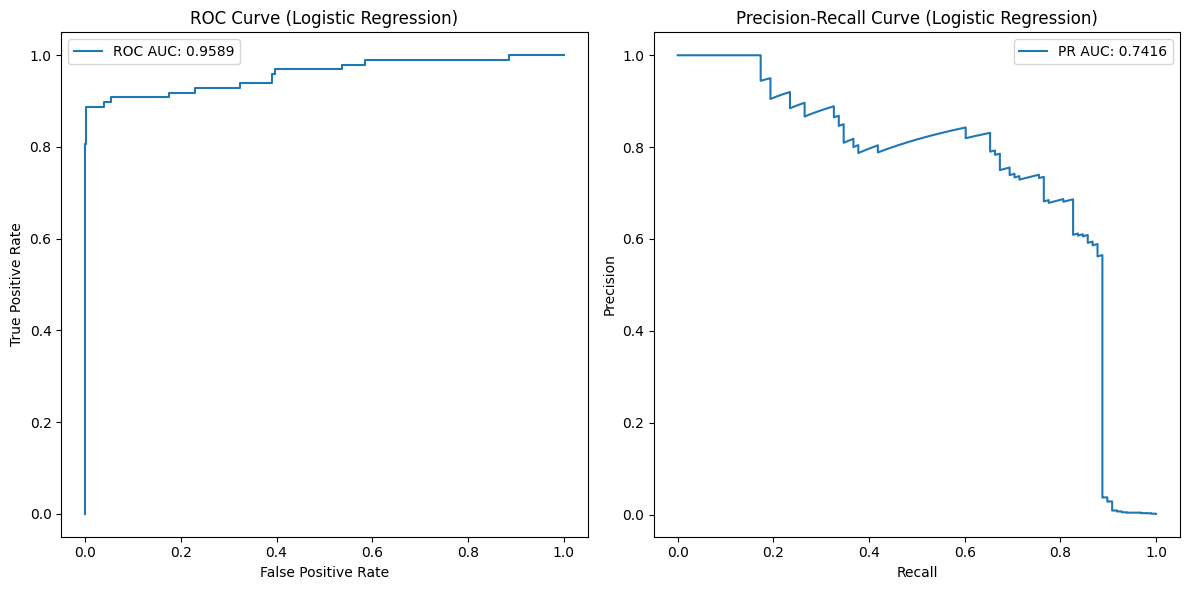

In [92]:
model = LogisticRegression(random_state=42)

y_pred, y_scores = train__supervised_classic(model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "Logistic Regression")
eval_logistic_regression = evaluate_model_cross_validation(model, credit_card_features.values, credit_card_labels.values, "Logistic Regression")


## Approche supervisée classique : Support Vector Machine

ROC AUC score :  0.8401845027511831
Average precision score :  0.24937922838236268
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.36      0.68      0.48       148

    accuracy                           1.00     85443
   macro avg       0.68      0.84      0.74     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC (SVC): 0.9686
PR AUC (SVC): 0.4161


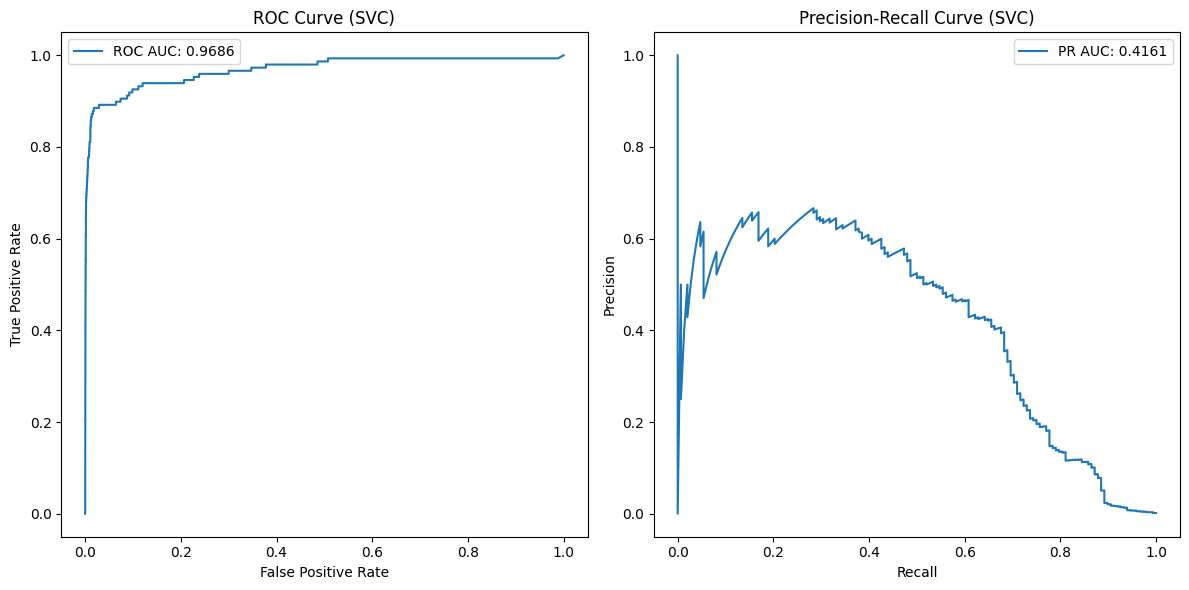

In [34]:
X_train, X_test, y_train, y_test = train_test_split(credit_card_features, credit_card_labels, test_size=0.3, stratify=credit_card_labels)

model = SVC(probability=True, class_weight='balanced', random_state=42)
y_pred, y_scores = train__supervised_classic(model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "SVC")

eval_support_vector = evaluate_model_cross_validation(model, credit_card_features.values, credit_card_labels.values, "SVC")

## UnderSampling - Tomek Links

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC AUC score :  0.8850647910352466
Average precision score :  0.697309123013979
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.77      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC (Tomek Links + Random Forest): 0.9444
PR AUC (Tomek Links + Random Forest): 0.8351


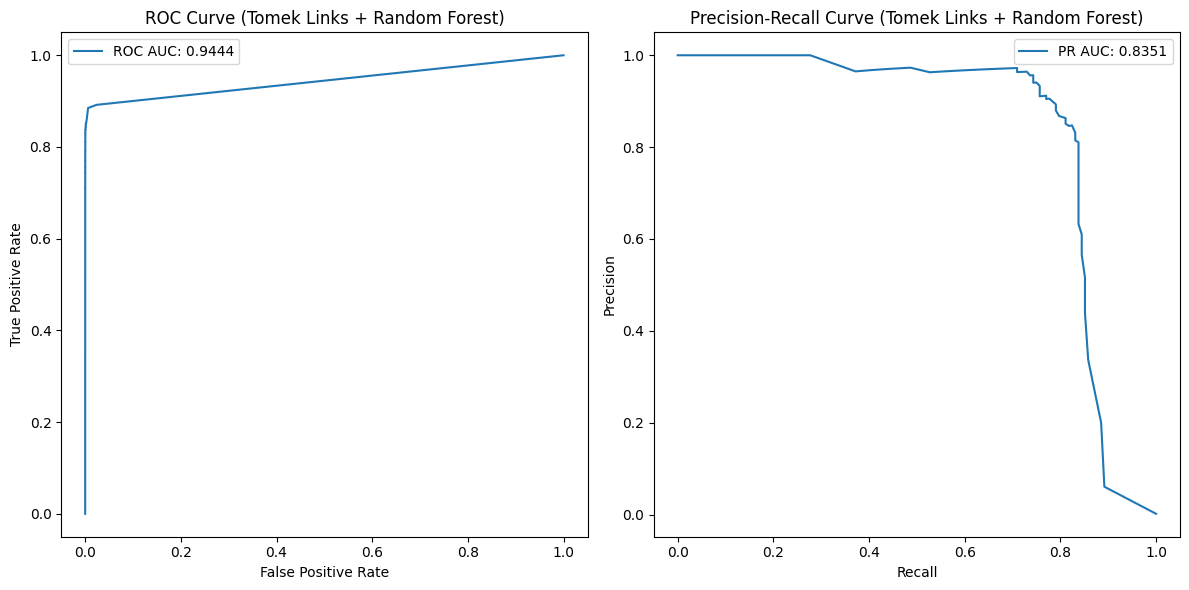

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The TomekLinks or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEs

In [35]:
tl = TomekLinks()
model = RandomForestClassifier(random_state=42)

y_pred, y_scores = train_supervised_imbalanced(tl, model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "Tomek Links + Random Forest")

eval_undersampling = evaluate_model_cross_validation(model, credit_card_features.values, credit_card_labels.values, "Tomek Links + Random Forest", use_resampling=True, resampler=tl)


## OverSampling

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


ROC AUC score :  0.8985079604488715
Average precision score :  0.6628939357818161
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.80      0.81       148

    accuracy                           1.00     85443
   macro avg       0.92      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC (SMOTE + Random Forest): 0.9726
PR AUC (SMOTE + Random Forest): 0.8374


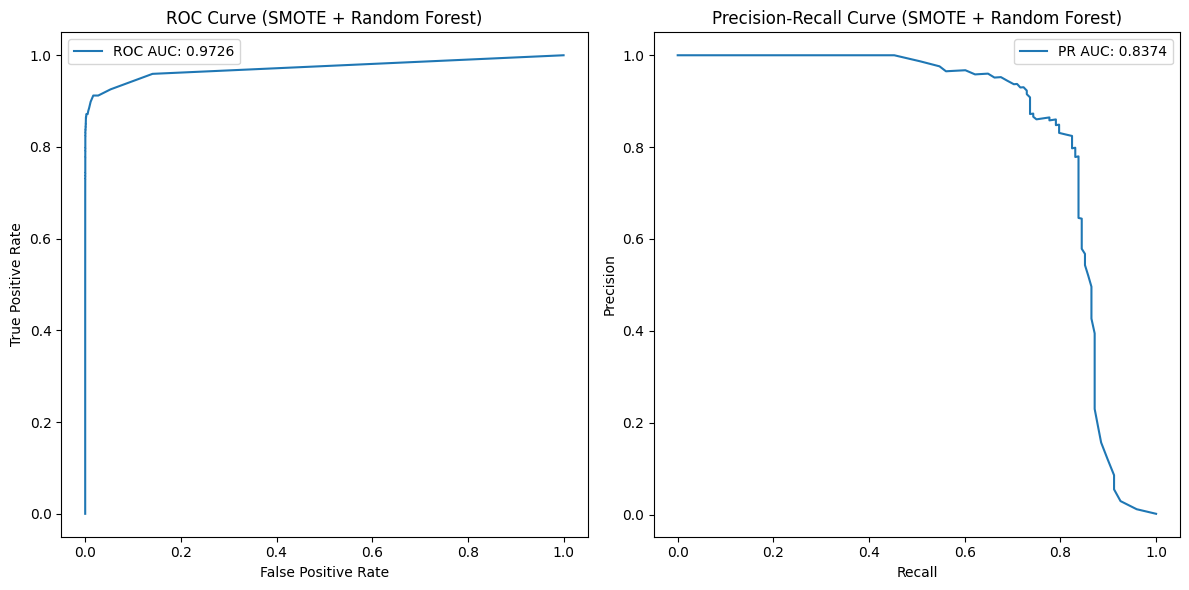

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimat

In [36]:
smote = SMOTE()
model = RandomForestClassifier(random_state=42)

y_pred, y_scores = train_supervised_imbalanced(smote, model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "SMOTE + Random Forest")

eval_oversampling = evaluate_model_cross_validation(model, credit_card_features.values, credit_card_labels.values, "SMOTE + Random Forest", use_resampling=True, resampler=smote)


## Balancing

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

ROC AUC score :  0.9269903498668374
Average precision score :  0.05185661392863157
Classifier report : 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC (Balanced Random Forest): 0.9754
PR AUC (Balanced Random Forest): 0.7263


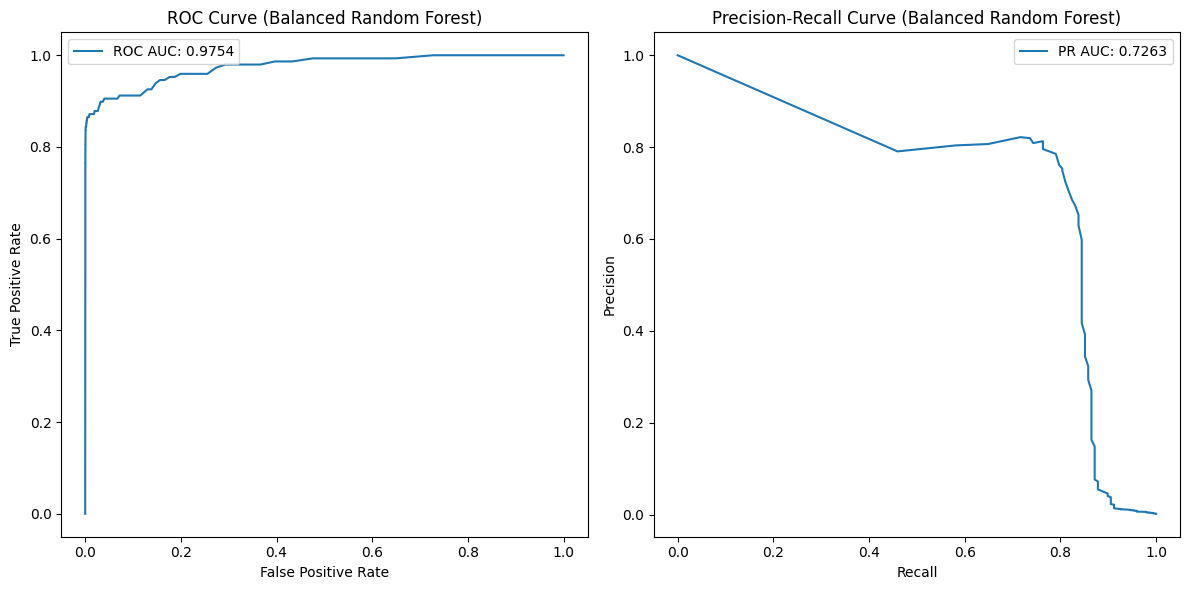

c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\tomhu\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to

In [37]:
model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
y_pred, y_scores = train__supervised_classic(model, X_train, X_test, y_train, y_test)

print_metrics(y_test, y_pred)

plot_roc_pr_curves((y_test, y_scores), "Balanced Random Forest")

eval_balancing = evaluate_model_cross_validation(model, credit_card_features.values, credit_card_labels.values, "Balanced Random Forest")

## Isolation Forest

ROC AUC (Isolation Forest): 0.9417
PR AUC (Isolation Forest): 0.1628


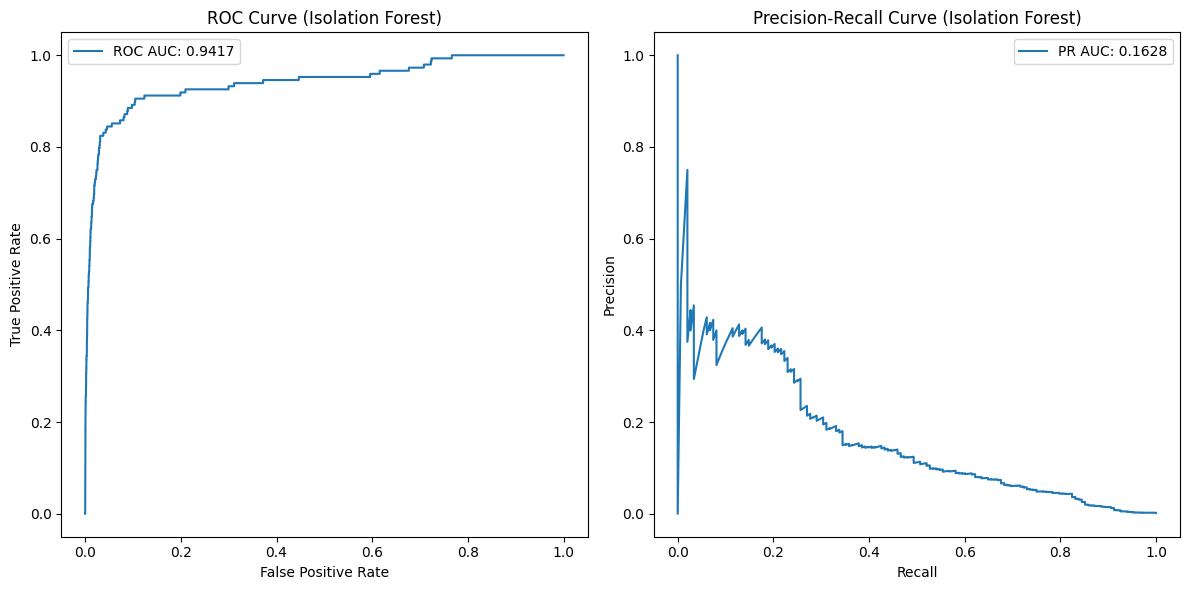

In [38]:
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest_results = train_and_evaluate_isforest(X_train, X_test, y_train, y_test, iso_forest)
plot_roc_pr_curves(iso_forest_results, 'Isolation Forest')
eval_isolation_forest = evaluate_model_cross_validation(iso_forest, credit_card_features.values, credit_card_labels.values, "Isolation Forest")

## Local Outlier Factor

In [42]:
n_neighbors_list = [5, 10, 20, 30, 50]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

result=[]
for n_neighbors in n_neighbors_list:
    x, y = train_and_evaluate_lof(X_train, X_test, y_train, y_test, n_neighbors)
    roc_auc = roc_auc_score(x, y)
    
    precision, recall, _ = precision_recall_curve(x, y)
    pr_auc = auc(recall, precision)
    result.append((n_neighbors, roc_auc, pr_auc))
    print(f'LOF with {n_neighbors} neighbors: ROC AUC = {roc_auc:.2f}, PR AUC = {pr_auc:.4f}')
    
best = max(result, key=lambda x: x[1])[0]
print(f'The best number of neighbors is {best}')


LOF with 5 neighbors: ROC AUC = 0.48, PR AUC = 0.0016
LOF with 10 neighbors: ROC AUC = 0.46, PR AUC = 0.0015
LOF with 20 neighbors: ROC AUC = 0.50, PR AUC = 0.0018
LOF with 30 neighbors: ROC AUC = 0.49, PR AUC = 0.0018
LOF with 50 neighbors: ROC AUC = 0.48, PR AUC = 0.0016
The best number of neighbors is 20


Le meilleur hyperparamètre pour l'Isolation Forest est nombre de voisin de 5.

ROC AUC (Local Outlier Factor): 0.4956
PR AUC (Local Outlier Factor): 0.0018


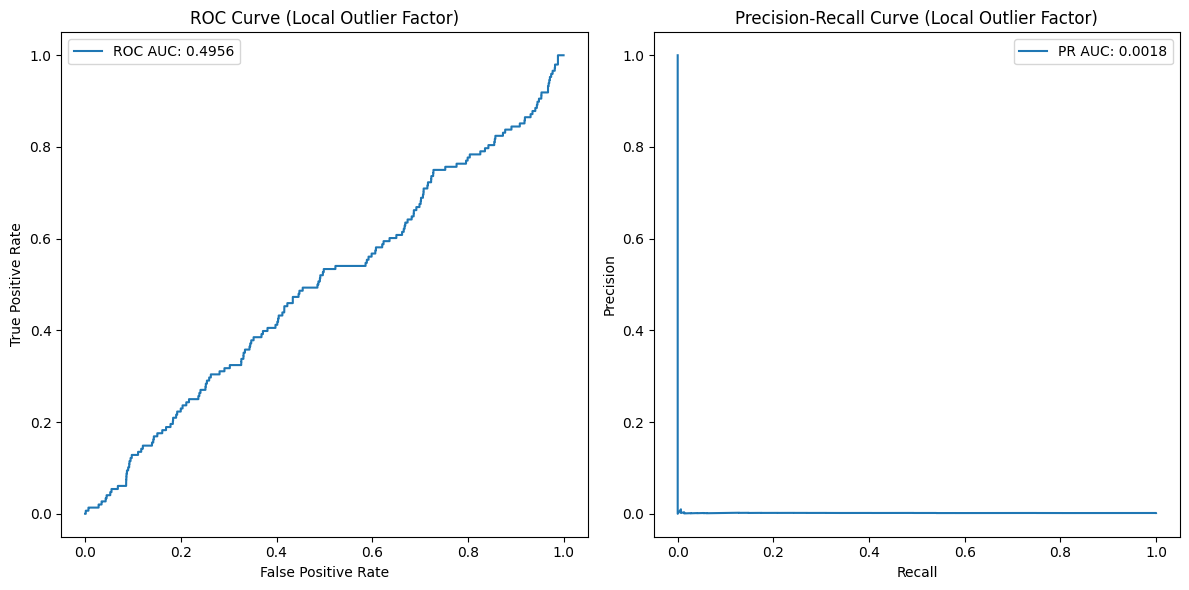

In [43]:
lof_results = train_and_evaluate_lof(X_train, X_test, y_train, y_test, 20)
plot_roc_pr_curves(lof_results, 'Local Outlier Factor')
eval_lof = evaluate_model_cross_validation(LocalOutlierFactor(n_neighbors=20,contamination=0.05, novelty=True), credit_card_features.values, credit_card_labels.values, "Local Outlier Factor")

## Comparaison basée sur la validation croisée stratifiée

                         Model   ROC AUC    PR AUC  ROC AUC Std  PR AUC Std
0          Logistic Regression  0.974538  0.757146     0.008304    0.019910
1                          SVC  0.974612  0.480345     0.005969    0.045690
2  Tomek Links + Random Forest  0.952760  0.852940     0.014248    0.027867
3        SMOTE + Random Forest  0.971343  0.854979     0.012273    0.023267
4       Balanced Random Forest  0.980052  0.792531     0.005993    0.029760
5             Isolation Forest  0.950641  0.141575     0.009060    0.011666
6         Local Outlier Factor  0.497475  0.001910     0.009012    0.000125


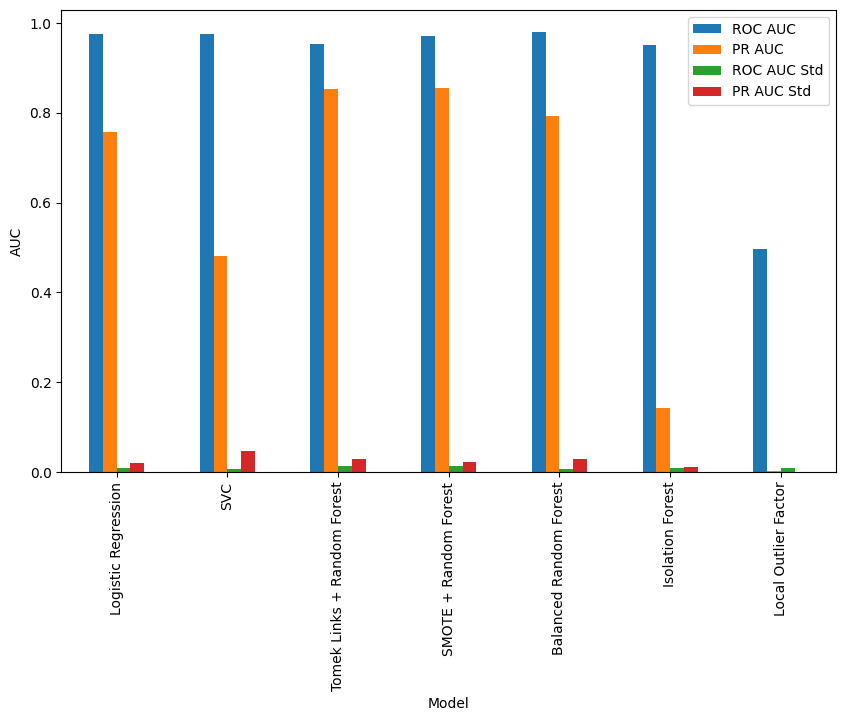

In [55]:
compare_results = []
compare_results.append(eval_logistic_regression)
compare_results.append(eval_support_vector)
compare_results.append(eval_undersampling)
compare_results.append(eval_oversampling)
compare_results.append(eval_balancing)
compare_results.append(eval_isolation_forest)
compare_results.append(eval_lof)

compare_results = pd.DataFrame(compare_results)
print(compare_results)
compare_results.set_index('Model', inplace=True)
compare_results.plot(kind='bar', figsize=(10, 6))
plt.ylabel('AUC')
plt.show()


On peut voir ici que la méthode de **Balanced Random Forest** est la meilleure méthode pour ce problème. Elle obtient le meilleur score en ROC AUC, ce qui veut dire qu'elle est robuste ainsi qu'un très bon score PR AUC qui est très bon pour les problèmes de déséquilibre de classe.

## APPLICATION SUR LE JEU DE DONNÉES Kddcup99

On décidé d'appliquer la méthodologie de l'échantillonnage aléatoire stratifié sur le jeu de données Kddcup99 car la validation croisée stratifiée prenait beaucoup trop de temps

In [7]:
from utilsfunction import preprocess_data2, methodological_approach

In [8]:
kdd_cup99 = pd.read_csv('KDDCup99.csv')
kdd_cup99_features, kdd_cup99_labels = preprocess_data2(kdd_cup99)

kdd_cup99_features = pd.DataFrame(kdd_cup99_features)

X_train, X_test, y_train, y_test = train_test_split(kdd_cup99_features, kdd_cup99_labels, test_size=0.3, random_state=42, stratify=kdd_cup99_labels)

In [10]:
#methodological_approach(X_train, X_test, y_train, y_test)